text_width 6.75
column_width 3.25


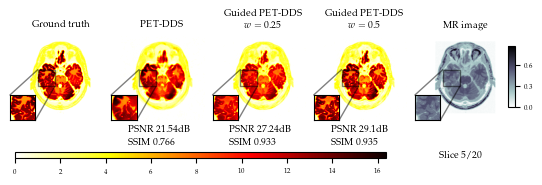

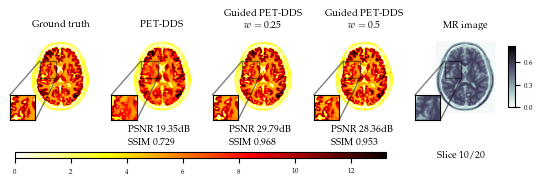

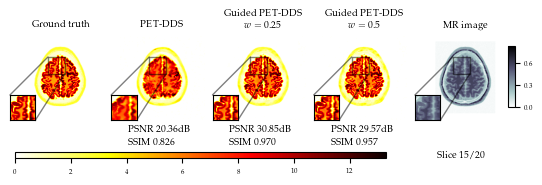

In [15]:
import matplotlib, os, torch
import numpy as np
import matplotlib.pyplot as plt
from result_util import get_sweep_mean_results
import matplotlib.patches as mpatches

text_width = (72.27 ** -1) * 487.8225 # in  --> Confirmed with template explanation
print('text_width', text_width)
column_width = (72.27 ** -1) * 234.8775
print('column_width', column_width)

fs_m1 = 5  # for figure ticks
fs = 7  # for regular figure text
fs_p1 = 8  # figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title
matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)

MEAN_KLDIV = 59407.19626953125

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

gt = torch.load("/home/user/sirf/results/2D_final/noise_level=2.5/non_tumour/ground_truth.pt")
mri = torch.load("/home/user/sirf/results/2D_final/noise_level=2.5/non_tumour/mri.pt")

base_path = "/home/user/sirf/results/2D_final/noise_level=2.5/non_tumour"

method_to_name = {"vpsde_dds_anchor_epoch_10_guided_gstrength_0.25_.pt": r"Guided \textsc{PET-DDS}"+"\n"+r"$w=0.25$",
                "vpsde_dds_anchor_epoch_10_guided_gstrength_0.5_.pt": r"Guided \textsc{PET-DDS}"+"\n"+r"$w=0.5$",
                #"vpsde_dds_anchor_epoch_10_guided_gstrength_1.0_.pt": r"$w=1.0$",
                  "vpsde_dds_anchor_epoch_4_.pt": r"\textsc{PET-DDS}"}

method_to_id = {"vpsde_dds_anchor_epoch_10_guided_gstrength_0.25_.pt": 2,
                "vpsde_dds_anchor_epoch_10_guided_gstrength_0.5_.pt": 3,
                #"vpsde_dds_anchor_epoch_10_guided_gstrength_1.0_.pt": 4,
                  "vpsde_dds_anchor_epoch_4_.pt": 1}



methods = list(method_to_name.keys())


methods.sort(key = lambda x: method_to_id[x])

x0s = {5: 0.33, 10: 0.35, 15: 0.45}
y0s = {5: 0.5, 10: 0.6, 15: 0.65}

size = 0.1
for plot_img in [5, 10, 15]:
    fig, axes = plt.subplots(1, len(methods) + 2, figsize=(text_width,text_width/5))    
    x0 = x0s[plot_img]
    y0 = y0s[plot_img]        

    mri_img = mri[plot_img, :, :].swapaxes(0,1).numpy()[::-1,::-1]
    im = axes[-1].imshow(mri_img, cmap="bone_r", extent=(0,1,0,1))
    axes[-1].set_title("MR image")
    axes[-1].axis("off")
    axins = axes[-1].inset_axes([-.1, 0, 0.3, 0.3])
    axins.imshow(mri_img, extent=(0, 1, 0, 1), cmap="bone_r")
    axins.set_xlim(x0-size, x0+size)
    axins.set_ylim(y0-size, y0+size)
    axins.set_xticklabels([]); axins.set_yticklabels([]); axins.get_xaxis().set_ticks([]); axins.get_yaxis().set_ticks([])
    axes[-1].indicate_inset_zoom(axins, edgecolor="black")

    # left, bottom, width, height
    cbar_ax = fig.add_axes([0.85, 0.28, 0.01, 0.45])
    cb = fig.colorbar(im, cax=cbar_ax, shrink=0.2, fraction=0.046, ticks=[0,0.2,0.4,0.6,0.8])
    tick_locator = matplotlib.ticker.MaxNLocator(nbins=3)
    cb.locator = tick_locator
    cb.update_ticks()
        
    gt_img = gt[plot_img, :, :].swapaxes(0,1).numpy()[::-1,::-1]
    im = axes[0].imshow(gt_img, cmap="hot_r", extent=(0,1,0,1))
    vmax = gt_img.max()
    vmin = gt_img.min() 
    axes[0].axis("off")
    axes[0].set_title("Ground truth")
    axins = axes[0].inset_axes([-.1, 0, 0.3, 0.3])
    axins.imshow(gt_img, extent=(0, 1, 0, 1), vmin=vmin, vmax=vmax, cmap="hot_r")
    axins.set_xlim(x0-size, x0+size)
    axins.set_ylim(y0-size, y0+size)
    axins.set_xticklabels([]); axins.set_yticklabels([]); axins.get_xaxis().set_ticks([]); axins.get_yaxis().set_ticks([])
    axes[0].indicate_inset_zoom(axins, edgecolor="black")

    for idx, method in enumerate(methods):

        res = torch.load(os.path.join(base_path, method))
        keys = list(res.keys())
        keys_psnr = [] 
        keys_ssim = []
        keys_crc = []
        keys_weighted = [] 
        for key in keys:
            psnr_list = [] 
            ssim_list = []
            for img_idx in res[key].keys():
                psnr_list.append(float(res[key][img_idx]['psnr']))
                ssim_list.append(float(res[key][img_idx]['ssim']))
            keys_psnr.append(np.mean(psnr_list))
            keys_ssim.append(np.mean(ssim_list))
        
        best_key = keys[np.argmax(keys_ssim)]
        show_img = res[best_key][str(plot_img)]["images"].swapaxes(0,1).numpy()[::-1,::-1]
        axes[idx+1].imshow(show_img, cmap="hot_r",
                                vmin=vmin, vmax=vmax, extent=(0,1,0,1))
        axes[idx+1].axis("off")
        axes[idx+1].set_title(method_to_name[method])
        axes[idx+1].text(0.1, -0.15, "PSNR " + str(np.round(res[best_key][str(plot_img)]['psnr'].item(), 2)) + "dB", horizontalalignment="left")
        if len(str(np.round(res[best_key][str(plot_img)]['ssim'].item(), 3))) < 5:
            axes[idx+1].text(0.1, -0.3, "SSIM " + str(np.round(res[best_key][str(plot_img)]['ssim'].item(), 3))+"0" , horizontalalignment="left")
        else:
            axes[idx+1].text(0.1, -0.3, "SSIM " + str(np.round(res[best_key][str(plot_img)]['ssim'].item(), 3)) , horizontalalignment="left")
        axins = axes[idx+1].inset_axes([-.1, 0, 0.3, 0.3])
        axins.imshow(show_img, extent=(0, 1, 0, 1), vmin=vmin, vmax=vmax, cmap="hot_r")
        axins.set_xlim(x0-size, x0+size)
        axins.set_ylim(y0-size, y0+size)
        axins.set_xticklabels([]); axins.set_yticklabels([]); axins.get_xaxis().set_ticks([]); axins.get_yaxis().set_ticks([])
        axes[idx+1].indicate_inset_zoom(axins, edgecolor="black")
        
    fig.subplots_adjust(right=0.85)
    # left, bottom, width, height
    #[0.83, 0.40, 0.01, 0.45]
    cbar_ax = fig.add_axes([0.12, -0.1, 0.55, 0.05])
    fig.colorbar(im, cax=cbar_ax, shrink=0.2, fraction=0.046, ticks=[0,0.2,0.4,0.6,0.8])
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal", pad=0.25, aspect=100, shrink=0.8)
    fig.text(0.78,-.083, f'Slice {plot_img}/20', horizontalalignment='center', verticalalignment='center')
    #fig.colorbar(im, cax=cbar_ax, shrink=0.2, fraction=0.046)
    #fig.suptitle("Reconstruction for noise scale 2.5 with tumour")
    plt.savefig(f"guided_no_lesion_slice_{plot_img}.pdf", bbox_inches="tight", dpi=400)
    plt.show()

text_width 6.75
column_width 3.25


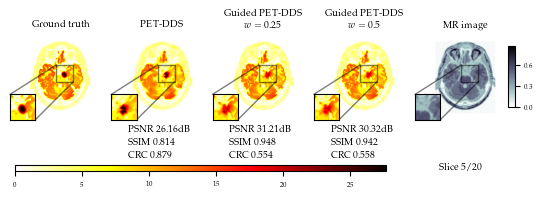

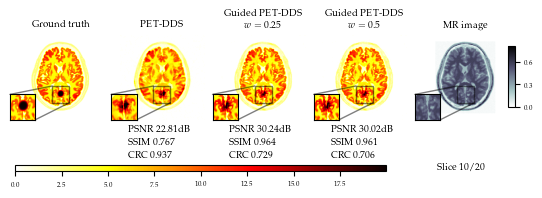

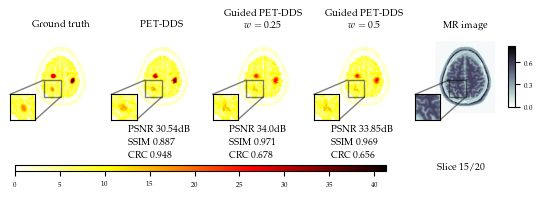

In [9]:
import matplotlib, os, torch
import numpy as np
import matplotlib.pyplot as plt
from result_util import get_sweep_mean_results
import matplotlib.patches as mpatches

text_width = (72.27 ** -1) * 487.8225 # in  --> Confirmed with template explanation
print('text_width', text_width)
column_width = (72.27 ** -1) * 234.8775
print('column_width', column_width)

fs_m1 = 5  # for figure ticks
fs = 7  # for regular figure text
fs_p1 = 8  # figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title
matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)

MEAN_KLDIV = 59407.19626953125

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

gt = torch.load("/home/user/sirf/results/2D_final/noise_level=2.5/tumour/ground_truth.pt")
mri = torch.load("/home/user/sirf/results/2D_final/noise_level=2.5/non_tumour/mri.pt")

base_path = "/home/user/sirf/results/2D_final/noise_level=2.5/tumour"

method_to_name = {"vpsde_dds_anchor_epoch_10_guided_gstrength_0.25_.pt": r"Guided \textsc{PET-DDS}"+"\n"+r"$w=0.25$",
                "vpsde_dds_anchor_epoch_10_guided_gstrength_0.5_.pt": r"Guided \textsc{PET-DDS}"+"\n"+r"$w=0.5$",
                #"vpsde_dds_anchor_epoch_10_guided_gstrength_1.0_.pt": r"$w=1.0$",
                  "vpsde_dds_anchor_epoch_4_.pt": r"\textsc{PET-DDS}"}

method_to_id = {"vpsde_dds_anchor_epoch_10_guided_gstrength_0.25_.pt": 2,
                "vpsde_dds_anchor_epoch_10_guided_gstrength_0.5_.pt": 3,
                #"vpsde_dds_anchor_epoch_10_guided_gstrength_1.0_.pt": 4,
                  "vpsde_dds_anchor_epoch_4_.pt": 1}



methods = list(method_to_name.keys())


methods.sort(key = lambda x: method_to_id[x])

x0s = {5: 0.55, 10: 0.5, 15: 0.4}
y0s = {5: 0.55, 10: 0.3, 15: 0.37}

size = 0.1
for plot_img in [5, 10, 15]:
    fig, axes = plt.subplots(1, len(methods) + 2, figsize=(text_width,text_width/5))    
    x0 = x0s[plot_img]
    y0 = y0s[plot_img]        

    mri_img = mri[plot_img, :, :].swapaxes(0,1).numpy()[::-1,::-1]
    im = axes[-1].imshow(mri_img, cmap="bone_r", extent=(0,1,0,1))
    axes[-1].set_title("MR image")
    axes[-1].axis("off")
    axins = axes[-1].inset_axes([-.1, 0, 0.3, 0.3])
    axins.imshow(mri_img, extent=(0, 1, 0, 1), cmap="bone_r")
    axins.set_xlim(x0-size, x0+size)
    axins.set_ylim(y0-size, y0+size)
    axins.set_xticklabels([]); axins.set_yticklabels([]); axins.get_xaxis().set_ticks([]); axins.get_yaxis().set_ticks([])
    axes[-1].indicate_inset_zoom(axins, edgecolor="black")

    # left, bottom, width, height
    cbar_ax = fig.add_axes([0.85, 0.28, 0.01, 0.45])
    cb = fig.colorbar(im, cax=cbar_ax, shrink=0.2, fraction=0.046, ticks=[0,0.2,0.4,0.6,0.8])
    tick_locator = matplotlib.ticker.MaxNLocator(nbins=3)
    cb.locator = tick_locator
    cb.update_ticks()
        
    gt_img = gt[plot_img, :, :].swapaxes(0,1).numpy()[::-1,::-1]
    im = axes[0].imshow(gt_img, cmap="hot_r", extent=(0,1,0,1))
    vmax = gt_img.max()
    vmin = gt_img.min() 
    axes[0].axis("off")
    axes[0].set_title("Ground truth")
    axins = axes[0].inset_axes([-.1, 0, 0.3, 0.3])
    axins.imshow(gt_img, extent=(0, 1, 0, 1), vmin=vmin, vmax=vmax, cmap="hot_r")
    axins.set_xlim(x0-size, x0+size)
    axins.set_ylim(y0-size, y0+size)
    axins.set_xticklabels([]); axins.set_yticklabels([]); axins.get_xaxis().set_ticks([]); axins.get_yaxis().set_ticks([])
    axes[0].indicate_inset_zoom(axins, edgecolor="black")

    for idx, method in enumerate(methods):

        res = torch.load(os.path.join(base_path, method))
        keys = list(res.keys())
        keys_psnr = [] 
        keys_ssim = []
        keys_crc = []
        keys_weighted = [] 
        for key in keys:
            psnr_list = [] 
            ssim_list = []
            for img_idx in res[key].keys():
                psnr_list.append(float(res[key][img_idx]['psnr']))
                ssim_list.append(float(res[key][img_idx]['ssim']))
            keys_psnr.append(np.mean(psnr_list))
            keys_ssim.append(np.mean(ssim_list))
        
        best_key = keys[np.argmax(keys_ssim)]
        show_img = res[best_key][str(plot_img)]["images"].swapaxes(0,1).numpy()[::-1,::-1]
        axes[idx+1].imshow(show_img, cmap="hot_r",
                                vmin=vmin, vmax=vmax, extent=(0,1,0,1))
        axes[idx+1].axis("off")
        axes[idx+1].set_title(method_to_name[method])
        psnr = peak_signal_noise_ratio(show_img, gt_img, data_range=vmax - vmin)
        ssim = structural_similarity(show_img, gt_img, data_range=vmax - vmin)
        axes[idx+1].text(0.1, -0.15, "PSNR " + str(np.round(res[best_key][str(plot_img)]['psnr'].item(), 2)) + "dB", horizontalalignment="left")
        axes[idx+1].text(0.1, -0.3, "SSIM " + str(np.round(res[best_key][str(plot_img)]['ssim'].item(), 3)) , horizontalalignment="left")
        axes[idx+1].text(0.1, -0.45, "CRC " + str(np.round(res[best_key][str(plot_img)]['crc'].item(), 3)) , horizontalalignment="left")
        axins = axes[idx+1].inset_axes([-.1, 0, 0.3, 0.3])
        axins.imshow(show_img, extent=(0, 1, 0, 1), vmin=vmin, vmax=vmax, cmap="hot_r")
        axins.set_xlim(x0-size, x0+size)
        axins.set_ylim(y0-size, y0+size)
        axins.set_xticklabels([]); axins.set_yticklabels([]); axins.get_xaxis().set_ticks([]); axins.get_yaxis().set_ticks([])
        axes[idx+1].indicate_inset_zoom(axins, edgecolor="black")
        
    fig.subplots_adjust(right=0.85)
    # left, bottom, width, height
    #[0.83, 0.40, 0.01, 0.45]
    cbar_ax = fig.add_axes([0.12, -0.2, 0.55, 0.05])
    fig.colorbar(im, cax=cbar_ax, shrink=0.2, fraction=0.046, ticks=[0,0.2,0.4,0.6,0.8])
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal", pad=0.25, aspect=100, shrink=0.8)
    fig.text(0.78,-.175, f'Slice {plot_img}/20', horizontalalignment='center', verticalalignment='center')
    #fig.colorbar(im, cax=cbar_ax, shrink=0.2, fraction=0.046)
    #fig.suptitle("Reconstruction for noise scale 2.5 with tumour")
    plt.savefig(f"guided_lesion_slice_{plot_img}.pdf", bbox_inches="tight", dpi=400)
    plt.show()